In [1]:
import os
import pandas as pd
import argparse
import warnings
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import *
from model import ANN
from torch import nn
import copy
from tqdm import tqdm
import random 
import numpy as np
from scipy import stats
from train import train_parameter, test_parameter, train_non_parameter, test_non_parameter
from model import ANN_gaussian, ANN_quantile
from model import DRO_parameter_layer
from optimization import SO_cvxpy_parameter,DRO_cvxpy_non_parameter
warnings.filterwarnings("ignore")
#torch.set_default_dtype(torch.float64)

In [2]:
set_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='no-parameter')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=5e-3)
parser_train.add_argument('--patience', type=int, default=20)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_lr', type=float, default=1e-5)
parser_train.add_argument('--ft_lr', type=int, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e2)
parser_train.add_argument('--epsion_l', type=float, default=1e2)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])

parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=300)
parser_train.add_argument('--x_max', type=int, default=10000)
parser_train.add_argument('--x_min', type=int, default=0)
parser_train.add_argument('--z_pos_max', type=int, default=5000)
parser_train.add_argument('--z_neg_max', type=int, default=5000)
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=1000)
parser_train.add_argument('--r_pos', type=int, default=1000)
parser_train.add_argument('--rho', type=list, default=[0.03 for i in range(24)])
parser_train.add_argument('--rho_pos', type=list, default=[0.05 for i in range(24)])
parser_train.add_argument('--rho_neg', type=list, default=[0.01 for i in range(24)])
parser_train.add_argument('--upper_quantiles', type=float, default=0.999)
parser_train.add_argument('--lower_quantiles', type=float, default=0.001)
parser_train.add_argument('--epsion', type=float, default=1)

args_train = parser_train.parse_args(args=[])

In [4]:
train_load_data,train_load_loader=get_load_data(args_train,flag='train')
val_load_data,val_load_loader=get_load_data(args_train,flag='val')
test_load_data,test_load_loader=get_load_data(args_train,flag='test')

train_pv_data,train_pv_loader=get_pv_data(args_train,flag='train')
val_pv_data,val_pv_loader=get_pv_data(args_train,flag='val')
test_pv_data,test_pv_loader=get_pv_data(args_train,flag='test')


combined_train_data,combined_train_loader=get_combined_data(args_train,train_pv_data,train_load_data,flag='train')
combined_val_data,combined_val_loader=get_combined_data(args_train,val_pv_data,val_load_data,flag='val')
combined_fine_tune_data,combined_fine_tune_loader=get_combined_data(args_train,test_pv_data,test_load_data,flag='test')
combined_test_data,combined_test_loader=get_combined_data(args_train,test_pv_data,test_load_data,flag='test')


../Data/GEF_data/data.csv
(286, 24, 11)
(286, 24)
../Data/GEF_data/data.csv
(72, 24, 11)
(72, 24)
../Data/GEF_data/data.csv
(365, 24, 11)
(365, 24)
../Data/PV/PV.csv
(286, 24, 11)
(286, 24)
../Data/PV/PV.csv
(72, 24, 11)
(72, 24)
../Data/PV/PV.csv
(365, 24, 11)
(365, 24)
Test data is not shuffled
Test data is not shuffled


### load forecasting

In [5]:
input_size=train_load_data.X.shape[-1]
output_size=len(args_train.quantiles)
model_load=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles).to(device)
train_non_parameter(args_train, model_load, train_load_loader, val_load_loader,dir_best_model='../Model/best_ann_load.pt')

Epoch 0, Train Loss: 0.16382880202111075
Epoch [1/1000] Train Loss: 0.1638 Val Loss: 0.1205
Epoch [2/1000] Train Loss: 0.1060 Val Loss: 0.0938
Epoch [3/1000] Train Loss: 0.0943 Val Loss: 0.0892
Epoch [4/1000] Train Loss: 0.0842 Val Loss: 0.0870
Epoch [5/1000] Train Loss: 0.0773 Val Loss: 0.0770
Epoch [6/1000] Train Loss: 0.0726 Val Loss: 0.0759
Epoch [7/1000] Train Loss: 0.0695 Val Loss: 0.0757
Epoch [8/1000] Train Loss: 0.0689 Val Loss: 0.0708
Epoch [9/1000] Train Loss: 0.0640 Val Loss: 0.0735
Epoch [10/1000] Train Loss: 0.0626 Val Loss: 0.0761
Epoch 10, Train Loss: 0.06616050793844111
Epoch [11/1000] Train Loss: 0.0662 Val Loss: 0.0839
Epoch [12/1000] Train Loss: 0.0688 Val Loss: 0.0766
Epoch [13/1000] Train Loss: 0.0605 Val Loss: 0.0799
Epoch [14/1000] Train Loss: 0.0624 Val Loss: 0.0807
Epoch [15/1000] Train Loss: 0.0620 Val Loss: 0.0761
Epoch [16/1000] Train Loss: 0.0612 Val Loss: 0.0724
Epoch [17/1000] Train Loss: 0.0591 Val Loss: 0.0727
Epoch [18/1000] Train Loss: 0.0646 Val Los

Pinball Loss: 27.508049
Winkler Score: 515.2051391601562


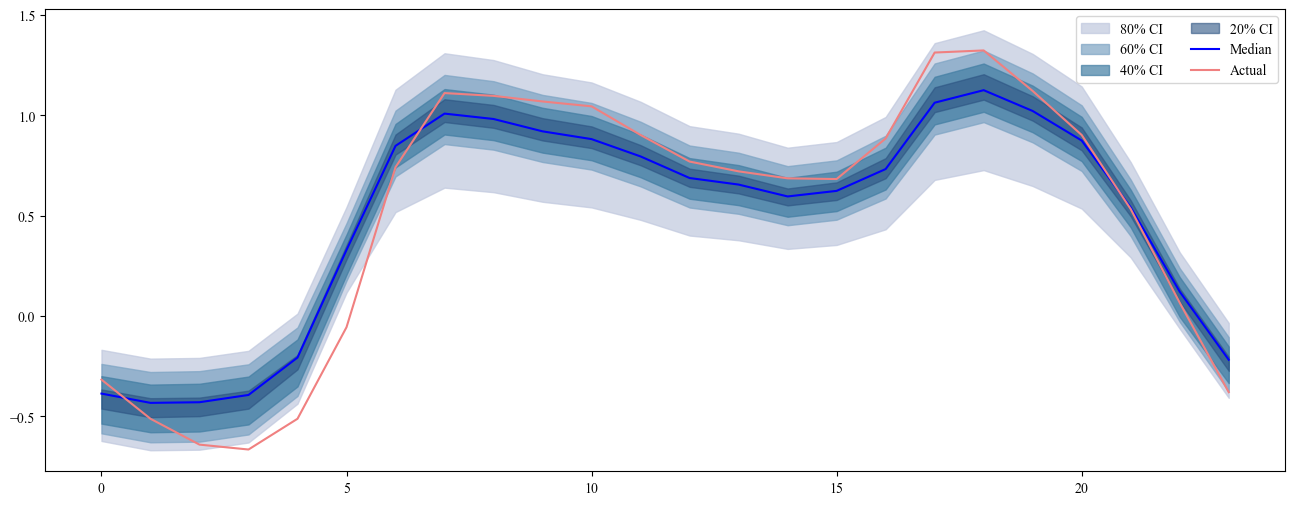

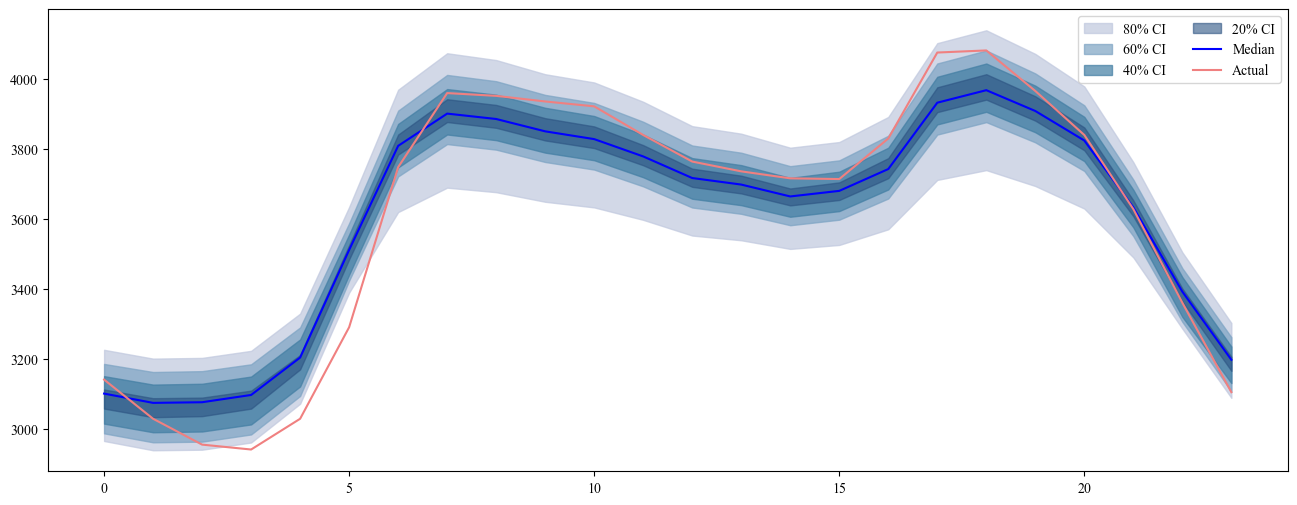

In [6]:
predictions_load,targets_load=test_non_parameter(args_train, model_load, test_load_loader)
predictions_load=predictions_load.cpu().detach().numpy()
predictions_load_inversed=train_load_data.inverse_transform(predictions_load.reshape(-1,1)).reshape(predictions_load.shape)
targets_load=targets_load.cpu().detach().numpy()
targets_load_inversed=train_load_data.inverse_transform(targets_load.reshape(-1,1)).reshape(targets_load.shape)
start=30
end=31
quantile_load_list={}
quantile_inverse_load_list={}

for i in range(len(args_train.quantiles)):
    quantile_load_list[args_train.quantiles[i]]=predictions_load[start:end,:,i].reshape(1,-1)[0]
    quantile_inverse_load_list[args_train.quantiles[i]]=predictions_load_inversed[start:end,:,i].reshape(1,-1)[0]
targets_load=targets_load[start:end].reshape(1,-1)[0]
targets_load_inversed=targets_load_inversed[start:end].reshape(1,-1)[0]


pinball_loss_value=pinball_loss_calculation(quantile_inverse_load_list, targets_load_inversed, args_train.quantiles)
winkler_score_value=winkler_score_calculation(quantile_inverse_load_list, targets_load_inversed, alpha=0.1)
print('Pinball Loss:', pinball_loss_value)
print('Winkler Score:', winkler_score_value)

plot_quantiles(quantile_load_list, targets_load)
plot_quantiles(quantile_inverse_load_list, targets_load_inversed)

### pv forecasting

In [7]:
input_size=train_pv_data.X.shape[-1]
model_pv=ANN_quantile(input_size=input_size, hidden_layers=args_train.hidden_layers, quantiles=args_train.quantiles).to(device)
train_non_parameter(args_train, model_pv, train_pv_loader, val_pv_loader,dir_best_model='../Model/best_ann_pv.pt')

Epoch 0, Train Loss: 0.15288401526563308
Epoch [1/1000] Train Loss: 0.1529 Val Loss: 0.1076
Epoch [2/1000] Train Loss: 0.0907 Val Loss: 0.0840
Epoch [3/1000] Train Loss: 0.0794 Val Loss: 0.0901
Epoch [4/1000] Train Loss: 0.0797 Val Loss: 0.0895
Epoch [5/1000] Train Loss: 0.0828 Val Loss: 0.0806
Epoch [6/1000] Train Loss: 0.0755 Val Loss: 0.0833
Epoch [7/1000] Train Loss: 0.0747 Val Loss: 0.0860
Epoch [8/1000] Train Loss: 0.0744 Val Loss: 0.0798
Epoch [9/1000] Train Loss: 0.0706 Val Loss: 0.0765
Epoch [10/1000] Train Loss: 0.0702 Val Loss: 0.0743
Epoch 10, Train Loss: 0.06932150419144069
Epoch [11/1000] Train Loss: 0.0693 Val Loss: 0.0895
Epoch [12/1000] Train Loss: 0.0727 Val Loss: 0.0793
Epoch [13/1000] Train Loss: 0.0743 Val Loss: 0.0864
Epoch [14/1000] Train Loss: 0.0681 Val Loss: 0.0754
Epoch [15/1000] Train Loss: 0.0676 Val Loss: 0.0777
Epoch [16/1000] Train Loss: 0.0641 Val Loss: 0.0746
Epoch [17/1000] Train Loss: 0.0659 Val Loss: 0.0763
Epoch [18/1000] Train Loss: 0.0652 Val Los

Pinball Loss: 57.29781
Winkler Score: 604.6525573730469


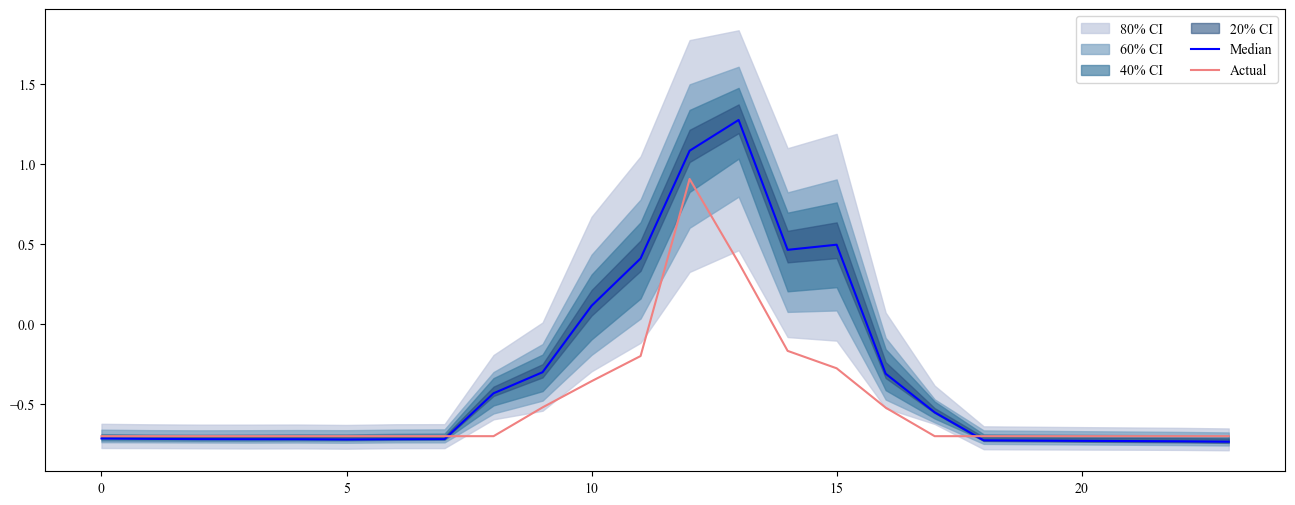

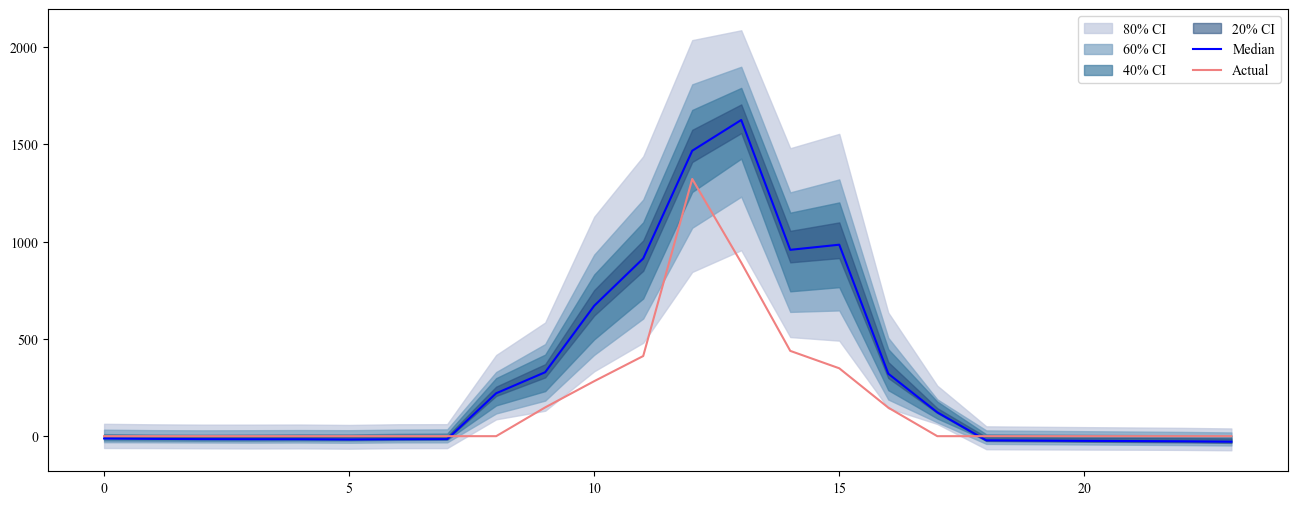

In [8]:
predictions_pv,targets_pv=test_non_parameter(args_train, model_pv, test_pv_loader)
predictions_pv=predictions_pv.cpu().detach().numpy()
predictions_pv_inversed=train_pv_data.inverse_transform(predictions_pv.reshape(-1,1)).reshape(predictions_pv.shape)
targets_pv=targets_pv.cpu().detach().numpy()
targets_pv_inversed=train_pv_data.inverse_transform(targets_pv.reshape(-1,1)).reshape(targets_pv.shape)
start=30
end=31
quantile_pv_list={}
quantile_inverse_pv_list={}

for i in range(len(args_train.quantiles)):
    quantile_pv_list[args_train.quantiles[i]]=predictions_pv[start:end,:,i].reshape(1,-1)[0]
    quantile_inverse_pv_list[args_train.quantiles[i]]=predictions_pv_inversed[start:end,:,i].reshape(1,-1)[0]
targets_pv=targets_pv[start:end].reshape(1,-1)[0]
targets_pv_inversed=targets_pv_inversed[start:end].reshape(1,-1)[0]


pinball_loss_value=pinball_loss_calculation(quantile_inverse_pv_list, targets_pv_inversed, args_train.quantiles)
winkler_score_value=winkler_score_calculation(quantile_inverse_pv_list, targets_pv_inversed, alpha=0.1)
print('Pinball Loss:', pinball_loss_value)
print('Winkler Score:', winkler_score_value)

plot_quantiles(quantile_pv_list, targets_pv)
plot_quantiles(quantile_inverse_pv_list, targets_pv_inversed)

In [9]:

class CombinedDataset(torch.nn.Module):
    def __init__(self, DRO_parameter_layer,model_pv, model_load,epsion_pv=1e-2, epsion_load=1e-2):
        super(CombinedDataset, self).__init__()
        self.model_pv = model_pv
        self.model_load = model_load
        self.DRO_parameter_layer = DRO_parameter_layer.cvxpyLayer
        self.epsion_pv = epsion_pv
        self.epsion_load = epsion_load
        
    def model_pv_forward(self, x, scaler_y):
        mean_torch = torch.tensor(scaler_y.mean_, dtype=torch.float64).to(x.device)
        scale_torch = torch.tensor(scaler_y.scale_, dtype=torch.float64).to(x.device)

        predictions=self.model_pv(x)
        predictions=(predictions.reshape(-1,1)* scale_torch + mean_torch).reshape(-1,24,predictions.shape[-1])

        return predictions

    def model_load_forward(self, x, scaler_y):
        mean_torch = torch.tensor(scaler_y.mean_, dtype=torch.float64).to(x.device)
        scale_torch = torch.tensor(scaler_y.scale_, dtype=torch.float64).to(x.device)

        predictions=self.model_load(x)
        predictions=(predictions.reshape(-1,1)* scale_torch + mean_torch).reshape(-1,24,predictions.shape[-1])
        return predictions
    
    def switch_solution_to_dict(self,solution):
        solution_dict={}
        variables_name=['x', 'z', 'phi', 'gamma_l', 'gamma_p', 'z_for_xi_max', 'z_for_xi_min']
        
        for name_index in range(len(variables_name)):
            solution_dict[variables_name[name_index]]=solution[name_index]
        return solution_dict

    def forward(self,args, p_quantile_list,l_quantile_list, p_targets,l_targets, quantiles):
        N = args.N
        T = args.T
        forecasts_pv = p_quantile_list[0.5].reshape(-1,24)
        forecasts_load = l_quantile_list[0.5].reshape(-1,24)
        forecasts_pv[forecasts_pv<0]=0
        
        l_quantile_list[0]=l_quantile_list[quantiles[0]]-(l_quantile_list[quantiles[1]]-l_quantile_list[quantiles[0]])/(quantiles[1]-quantiles[0])*quantiles[0]
        l_quantile_list[1]=l_quantile_list[quantiles[-1]]+(l_quantile_list[quantiles[-1]]-l_quantile_list[quantiles[-2]])/(quantiles[-1]-quantiles[-2])*(1-quantiles[-1])
        p_quantile_list[0]=p_quantile_list[quantiles[0]]-(p_quantile_list[quantiles[1]]-p_quantile_list[quantiles[0]])/(quantiles[1]-quantiles[0])*quantiles[0]
        p_quantile_list[1]=p_quantile_list[quantiles[-1]]+(p_quantile_list[quantiles[-1]]-p_quantile_list[quantiles[-2]])/(quantiles[-1]-quantiles[-2])*(1-quantiles[-1])

        quantiles_extend=[0]+args.quantiles+[1]
        
        quantile_load_tensor=torch.stack([l_quantile_list[i].reshape(-1,24) for i in quantiles_extend])
        quantile_pv_tensor=torch.stack([p_quantile_list[i].reshape(-1,24) for i in quantiles_extend])
        quantiles_extend=torch.tensor(quantiles_extend)
        

        xi_load_min,xi_load_max,samples_load = self.samples_generation(args, quantile_load_tensor, l_targets, quantiles_extend)
        xi_pv_min,xi_pv_max,samples_pv= self.samples_generation(args, quantile_pv_tensor, p_targets, quantiles_extend)
        
        for i in range(args.N):
            for j in range(args.T):
                samples_pv[:, i, j] = torch.where(forecasts_pv[:, j] <= samples_pv[:, i, j], forecasts_pv[:, j], samples_pv[:, i, j])

        rho=torch.tensor(args.rho,dtype=torch.float64).to(args.device)
        epsion_p=torch.tensor(args.epsion_p,dtype=torch.float64).to(args.device)
        epsion_l=torch.tensor(args.epsion_l,dtype=torch.float64).to(args.device)
        
        solution = self.DRO_parameter_layer(forecasts_pv, forecasts_load, 
                                 xi_pv_min, xi_pv_max, xi_load_min, xi_load_max, 
                                 samples_pv, samples_load, epsion_p,epsion_l,solver_args={'max_iters': 100000,'solve_method':'ECOS'})

        solution_dict=self.switch_solution_to_dict(solution)
        
        obj = solution_dict['x'][:,0:args.T]@ rho \
                + torch.mean(solution_dict['phi'], dim=1) \
                + solution_dict['gamma_l'] * epsion_l  \
                + solution_dict['gamma_p'] * epsion_p

        return solution_dict, obj

    def samples_generation(self,args,quantile_tensor,targets,quantiles):
        samples=torch.rand((args.N,args.T))
        quantile_tensor=quantile_tensor.permute(1, 0, 2)
        indices = torch.searchsorted(torch.tensor(quantiles),samples)

        samples_result=torch.zeros((quantile_tensor.shape[0],args.N,args.T)).to(args.device)
        for i in range(quantile_tensor.shape[0]):
            quantile_tensor_i = quantile_tensor[i]#.to(args.device)
            y0 = quantile_tensor_i[indices - 1, torch.arange(args.T)]#.to(args.device)
            y1 = quantile_tensor_i[indices, torch.arange(args.T)]#.to(args.device)
            x0 = torch.tensor(quantiles)[indices - 1].to(args.device)
            x1 = torch.tensor(quantiles)[indices].to(args.device)
            samples=samples.to(args.device)

            samples=samples.to(args.device)
            samples_result[i] = y0 + (samples - x0) * (y1 - y0) / (x1 - x0)


        samples_result=samples_result-targets.unsqueeze(1)
        xi_min = quantile_tensor[:,1]-targets
        xi_max = quantile_tensor[:,-2]-targets
        return xi_min, xi_max, samples_result

In [10]:
from optimization import SO_cvxpy_parameter,DRO_cvxpy_parameter

In [11]:

def E2E_fine_tuning_non_parameter(args, combined_model, data, scaler_y_pv,scaler_y_load, optimizer_mu):
    optimizer_mu.zero_grad()
    input_pv=data[0]
    input_load=data[1]
    labels_pv=data[2]
    labels_load=data[3]
    input_pv=input_pv.reshape(-1,input_pv.shape[-1])
    input_load=input_load.reshape(-1,input_load.shape[-1])
        
    predictions_load = combined_model.model_load_forward(input_load,scaler_y_load)
    predictions_pv = combined_model.model_pv_forward(input_pv,scaler_y_pv)
    quantile_pv_list={}
    quantile_load_list={}
    for i in range(len(args.quantiles)):
        quantile_pv_list[args.quantiles[i]]=predictions_pv[:,:,i]#.reshape(1,-1)[0]
        quantile_load_list[args.quantiles[i]]=predictions_load[:,:,i]#.reshape(1,-1)[0]
        
    scaler_pv_mean = torch.tensor(scaler_y_pv.mean_,dtype=torch.float64).to(device)
    scaler_pv_scale = torch.tensor(scaler_y_pv.scale_,dtype=torch.float64).to(device)
    scaler_load_mean = torch.tensor(scaler_y_load.mean_,dtype=torch.float64).to(device)
    scaler_load_scale = torch.tensor(scaler_y_load.scale_,dtype=torch.float64).to(device)

    labels_load = (labels_load.reshape(-1,1)*scaler_load_scale+scaler_load_mean).reshape(-1,24)
    labels_pv = (labels_pv.reshape(-1,1)*scaler_pv_scale+scaler_pv_mean).reshape(-1,24)
    
    solution, obj = combined_model.forward(args_train, quantile_pv_list, quantile_load_list, labels_pv, labels_load, args_train.quantiles)
    loss=obj
    loss=loss.mean()
    loss.backward()
    optimizer_mu.step()
    return combined_model,loss


def traditional_fine_tuning_non_parameter(args,model, inputs,labels,optimizer):
    list_loss = []
    best_loss = float('inf')
    epochs_without_improvement = 0
    num_epochs = 10
    criterion = pinball_loss(args.quantiles)
    patience=5
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        optimizer.zero_grad()
        inputs = inputs.to(device).float()  # 确保输入数据是 Float 类型
        labels = labels.to(device).float()  # 确保标签数据是 Float 类型
        inputs=inputs.reshape(-1,inputs.shape[-1])
        labels=labels.reshape(-1,1)
        forecasts = model(inputs)

        loss = criterion(labels,forecasts)
        loss.backward()
        optimizer.step()
        list_loss.append(loss.item())
    
        # 检查是否有改善
        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # 如果连续的 epoch 没有改善，则停止训练
        if epochs_without_improvement >= patience:
            break

    return model, loss

def E2E_online_non_parameter(args, model_org, combined_model, combined_fine_tune_loader, combined_test_loader, scaler_y_pv, scaler_y_load):
    device = args.device
    cost_list = []
    solution_list = []
    forecasts_pv={}
    forecasts_load={}
    for i in args.quantiles:
        forecasts_pv[i]=[]
        forecasts_load[i]=[]
    batch_idx=0

    optimizer_mu = torch.optim.SGD([
    {'params': combined_model.model_pv.output_layers.parameters()},  
    {'params': combined_model.model_load.output_layers.parameters()}
    ], lr=args.e2e_lr)

    optimizer_sigma_load = torch.optim.SGD([
    {'params': combined_model.model_load.output_quantiles.parameters()},
    ], lr=args.ft_lr)
    
    optimizer_sigma_pv = torch.optim.SGD([
    {'params': combined_model.model_pv.output_quantiles.parameters()},
    ], lr=args.ft_lr)

    data_iter = iter(combined_test_loader)
    next(data_iter)
    plot_flag=False
    for input_pv, input_load, labels_pv, labels_load in combined_fine_tune_loader:
        batch_idx +=1
        if batch_idx>50:
            plot_flag=True
        print('=======================')
        print('New test batch',batch_idx)
        combined_model.train()
        input_pv = input_pv.to(device).float()
        input_load = input_load.to(device).float()
        labels_pv = labels_pv.to(device).float()
        labels_load = labels_load.to(device).float()

        try:
            input_pv_test, input_load_test, labels_pv_test, labels_load_test = next(data_iter)
            # 处理数据
        except StopIteration:
            print("No more data to read.")
            break

        input_pv_test = input_pv_test.to(device).float()
        input_load_test = input_load_test.to(device).float()
        labels_pv_test = labels_pv_test.to(device).float()
        labels_load_test = labels_load_test.to(device).float()
        test_data=[input_pv_test, input_load_test, labels_pv_test, labels_load_test]
        
        # set_seed(42)
        # solution, obj,_,_,_,_ = Evaluation_non_parameter(args, combined_model, test_data, scaler_y_pv, scaler_y_load,plot_flag=False,accuracy_flag=False)
        # print(f"Test Objective fine tune before: {obj.mean().item()}")
        # set_seed(42)
        # print('Accuracy Original')
        # solution_org, obj_org,_,_,_,_  = Evaluation_non_parameter(args, model_org, test_data, scaler_y_pv, scaler_y_load,plot_flag=plot_flag,accuracy_flag=True)
        # print(f"Original Test Objective: {obj_org.mean().item()}")

        for i in range(1):
            combined_model, _ = E2E_fine_tuning_non_parameter(args, combined_model, [input_pv, input_load, labels_pv, labels_load], scaler_y_pv, scaler_y_load, optimizer_mu)
            combined_model.model_pv, _ = traditional_fine_tuning_non_parameter(args,combined_model.model_pv, input_pv, labels_pv, optimizer_sigma_pv)
            combined_model.model_load, _ = traditional_fine_tuning_non_parameter(args,combined_model.model_load, input_load, labels_load, optimizer_sigma_load)

        print('Accuracy after fine tune')
        set_seed(42)
        solution, obj,quantiles_list_pv,quantiles_list_load,_,_ = Evaluation_non_parameter(args, combined_model, test_data, scaler_y_pv, scaler_y_load,plot_flag=plot_flag,accuracy_flag=True)
        if solution_list==[]:
            solution_list=solution
        else:
            for i in solution.keys():   
                solution_list[i]=torch.cat([solution_list[i],solution[i]])
        print(f"Test Objective: {obj.mean().item()}")
        cost_list+=list(obj.detach().cpu().numpy())
        
        for i in quantiles_list_pv.keys():
            forecasts_pv[i]=list(forecasts_pv[i])+list(quantiles_list_pv[i])
            forecasts_load[i]=list(forecasts_load[i])+list(quantiles_list_load[i])

    return solution_list, cost_list, forecasts_pv,forecasts_load

In [13]:
Opt_layer = DRO_parameter_layer(args_train)
model_org=  CombinedDataset(Opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
model_org.to(device)

CombinedDataset(
  (model_pv): ANN_quantile(
    (output_layers): Linear(in_features=128, out_features=1, bias=True)
    (output_quantiles): Linear(in_features=128, out_features=18, bias=True)
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
  )
  (model_load): ANN_quantile(
    (output_layers): Linear(in_features=128, out_features=1, bias=True)
    (output_quantiles): Linear(in_features=128, out_features=18, bias=True)
    (hidden_layers): Sequential(
      (0): Linear(in_features=11, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
  )
  (DRO_parameter_layer): CvxpyLayer()
)

In [14]:

batch_idx=0
cost_org=[]
solution_list_org=[]
targets_pv_list=[]  
targets_load_list=[]
forecasts_load_org={}
forecasts_pv_org={}
for i in args_train.quantiles:
    forecasts_pv_org[i]=[]
    forecasts_load_org[i]=[]

data_iter = iter(combined_test_loader)
next(data_iter)
while True:
    try:
        input_pv_test, input_load_test, labels_pv_test, labels_load_test = next(data_iter)
        batch_idx+=1
        input_pv_test = input_pv_test.to(device).float()
        input_load_test = input_load_test.to(device).float()
        labels_pv_test = labels_pv_test.to(device).float()
        labels_load_test = labels_load_test.to(device).float()
        set_seed(42)
        test_data=[input_pv_test, input_load_test, labels_pv_test, labels_load_test]
        solution_org, obj_org, quantiles_list_pv,quantiles_list_load,targets_pv,targets_load = Evaluation_non_parameter(args_train, model_org, test_data, train_pv_data.scaler_y,train_load_data.scaler_y,plot_flag=False)
        cost_org+=list(obj_org.detach().cpu().numpy())
        if solution_list_org==[]:
            solution_list_org=solution_org
        else:
            for i in solution_org.keys():   
                solution_list_org[i]=torch.cat([solution_list_org[i],solution_org[i]])
        for i in args_train.quantiles:
            forecasts_pv_org[i]=list(forecasts_pv_org[i])+list(quantiles_list_pv[i])
            forecasts_load_org[i]=list(forecasts_load_org[i])+list(quantiles_list_load[i])
        targets_pv_list+=list(targets_pv)
        targets_load_list+=list(targets_load)
    except StopIteration:
        break

--------------PV--------------
Pinball Loss: 51.45578768099786
Winkler Score_0.1: 615.1665042866019
MAE: 143.20954570179558
RMSE: 276.2034111648881
--------------Load--------------
Pinball Loss: 41.92840539493461
Winkler Score_0.1: 701.2690902184853
MAE: 113.39557765082645
RMSE: 138.10200927992878
--------------PV--------------
Pinball Loss: 38.49092251995442
Winkler Score_0.1: 549.1390069753975
MAE: 105.08582587814192
RMSE: 204.8348125572691
--------------Load--------------
Pinball Loss: 30.320134273767664
Winkler Score_0.1: 526.8141145646226
MAE: 82.49636257125903
RMSE: 100.95972840569627
--------------PV--------------
Pinball Loss: 56.4011905202362
Winkler Score_0.1: 921.9088488705022
MAE: 149.4424570476186
RMSE: 287.50428584999037
--------------Load--------------
Pinball Loss: 34.86245446178319
Winkler Score_0.1: 576.6989523431719
MAE: 93.3096324207185
RMSE: 118.31267132411533
--------------PV--------------
Pinball Loss: 46.70769680354885
Winkler Score_0.1: 796.8761399083021
MAE: 1

In [ ]:
combined_model =  CombinedDataset(Opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model.to(device)
set_seed(42)
solution_list, cost_list, forecasts_pv,forecasts_load = Traditional_online_non_parameter(args_train, combined_model, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.41069012147543
Winkler Score_0.1: 615.1611742883231
MAE: 142.8456606616424
RMSE: 276.1621680126772
--------------Load--------------
Pinball Loss: 41.704690010037204
Winkler Score_0.1: 699.0593985259493
MAE: 112.70301268178359
RMSE: 137.41955166730833
Test Objective: 2570.713148122396
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 38.41561769863419
Winkler Score_0.1: 549.2627887351942
MAE: 104.37310718710849
RMSE: 204.81831074666314
--------------Load--------------
Pinball Loss: 30.401785669361125
Winkler Score_0.1: 528.3048647050425
MAE: 82.60060689067298
RMSE: 101.18198946379378
Test Objective: 2558.3880653903148
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 56.305002511334024
Winkler Score_0.1: 922.1606303617598
MAE: 148.59185366168182
RMSE: 287.4517628908724
--------------Load--------------
Pinball Loss: 34.9277191

In [16]:
combined_model_e2e =  CombinedDataset(Opt_layer,copy.deepcopy(model_pv), copy.deepcopy(model_load))
combined_model_e2e.to(device)
set_seed(42)
solution_list_e2e, cost_list_e2e, forecasts_pv_e2e ,forecasts_load_e2e = E2E_online(args_train, model_org, combined_model_e2e, combined_fine_tune_loader, combined_test_loader, train_pv_data.scaler_y,train_load_data.scaler_y)

New test batch 1
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 51.41659243367603
Winkler Score_0.1: 615.3761731337493
MAE: 142.75704292387277
RMSE: 276.27517416537546
--------------Load--------------
Pinball Loss: 42.06943150424886
Winkler Score_0.1: 702.96085988992
MAE: 114.53689069474929
RMSE: 139.0700960364444
Test Objective: 2569.394003427105
New test batch 2
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 38.42399821035487
Winkler Score_0.1: 549.3374455727491
MAE: 104.50623673784551
RMSE: 204.95065276575534
--------------Load--------------
Pinball Loss: 30.259435846312094
Winkler Score_0.1: 525.7520618282489
MAE: 82.18131644165484
RMSE: 100.56916787159301
Test Objective: 2555.242683013923
New test batch 3
Accuracy after fine tune
--------------PV--------------
Pinball Loss: 56.31224955303691
Winkler Score_0.1: 921.9916222505354
MAE: 148.53880999766733
RMSE: 287.51879571711584
--------------Load--------------
Pinball Loss: 34.7271675113

In [58]:
print('Cost after e2e fine tune',np.mean(cost_list_e2e))
print('Cost after traditional fine tune',np.mean(cost_list))    
print('Cost before fine tune',np.mean(cost_org))
print('Cost decrease percent:',-(np.mean(cost_list_e2e)-np.mean(cost_org))/np.mean(cost_org)*100)
metric_list=['pinball_loss','winkler_score_0.1','winkler_score_0.2','winkler_score_0.3','MAE','RMSE']
print()
for i in args_train.quantiles:
    forecasts_pv[i]=np.array(forecasts_pv[i])
    forecasts_load[i]=np.array(forecasts_load[i])
    forecasts_pv_org[i]=np.array(forecasts_pv_org[i])
    forecasts_load_org[i]=np.array(forecasts_load_org[i])
    forecasts_pv_e2e[i]=np.array(forecasts_pv_e2e[i])
    forecasts_load_e2e[i]=np.array(forecasts_load_e2e[i])

print('Accuracy after e2e fine tune')
Metric_pv_org=calculate_accuracy(args_train, forecasts_pv_e2e, targets_pv_list,metric_list,return_flag=True)
Metric_load_org=calculate_accuracy(args_train, forecasts_load_e2e, targets_load_list,metric_list,return_flag=True)

print()
print('Accuracy after fine tune')
Metric_pv=calculate_accuracy(args_train, forecasts_pv, targets_pv_list,metric_list,return_flag=True)
Metric_load=calculate_accuracy(args_train, forecasts_load, targets_load_list,metric_list,return_flag=True)

print()
print('Accuracy before fine tune')
Metric_pv_e2e=calculate_accuracy(args_train, forecasts_pv_org, targets_pv_list,metric_list,return_flag=True)
Metric_load_e2e=calculate_accuracy(args_train, forecasts_load_org, targets_load_list,metric_list,return_flag=True)

Cost after e2e fine tune 2186.0980881221017
Cost after traditional fine tune 2208.80219826176
Cost before fine tune 2206.557115466981
Cost decrease percent: 0.9271922852787587

Accuracy after e2e fine tune
Pinball Loss: 65.293427417093
Winkler Score_0.1: 969.3253574061298
Winkler Score_0.2: 812.2278271158705
Winkler Score_0.3: 708.7562636721547
MAE: 175.50000938843326
RMSE: 327.0960228699643
Pinball Loss: 38.18995219772675
Winkler Score_0.1: 622.3861703747993
Winkler Score_0.2: 481.9198077418289
Winkler Score_0.3: 412.0768010932414
MAE: 106.69156319910167
RMSE: 137.76089015955995

Accuracy after fine tune
Pinball Loss: 63.93689143167148
Winkler Score_0.1: 962.950018701919
Winkler Score_0.2: 802.9932822962907
Winkler Score_0.3: 699.1358884779384
MAE: 166.81228805087028
RMSE: 325.61066024489685
Pinball Loss: 35.64557092269537
Winkler Score_0.1: 581.1562709731298
Winkler Score_0.2: 448.705882693793
Winkler Score_0.3: 382.7492236884537
MAE: 93.76178329018906
RMSE: 126.61652508779883

Accur

In [63]:
result_dic={
    'Original(PV)':Metric_pv_org,
    'TCL(PV)':Metric_pv,
    'E2E CL(PV)':Metric_pv_e2e,
    'Original(Load)':Metric_load_org,
    'TCL(Load)':Metric_load,
    'E2E CL(Load)':Metric_load_e2e
}

result_df=pd.DataFrame(result_dic).T
result_df.columns=metric_list
result_df.to_csv('../Result/Result_non_parameter.csv')
result_df

,pinball_loss,winkler_score_0.1,winkler_score_0.2,winkler_score_0.3,MAE,RMSE
Original(PV),65.293427,969.325357,812.227827,708.756264,175.500009,327.096023
TCL(PV),63.936891,962.950019,802.993282,699.135888,166.812288,325.610660
E2E CL(PV),64.435182,966.073860,807.384544,703.675843,168.856869,325.874313
Original(Load),38.189952,622.386170,481.919808,412.076801,106.691563,137.760890
TCL(Load),35.645571,581.156271,448.705883,382.749224,93.761783,126.616525
E2E CL(Load),36.327103,590.073987,456.102239,389.278745,95.741703,128.222791


Std variance_difference_org: 340.1387083623613
mean_difference_org: 49.6000430143362
Std variance_difference: 339.91651723099113
mean_difference: 39.05589542035767
Std variance_difference_e2e: 341.187977121429
mean_difference_e2e: 88.60466671161542


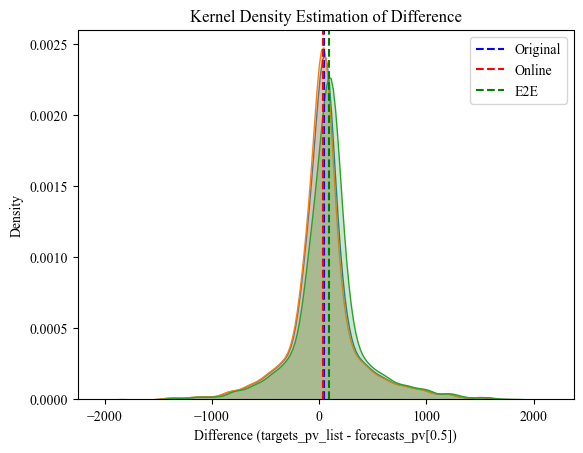

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
difference_org=  forecasts_pv_org[0.5]- targets_pv_list - forecasts_load_org[0.5]+ targets_load_list
difference= forecasts_pv[0.5]- targets_pv_list - forecasts_load[0.5]+ targets_load_list
difference_e2e= forecasts_pv_e2e[0.5]- targets_pv_list - forecasts_load_e2e[0.5]+ targets_load_list
# difference_org = difference_org[12::24]
# difference = difference[12::24]
# difference_e2e = difference_e2e[12::24]
mean_difference_org = np.mean(difference_org)
mean_difference = np.mean(difference)
mean_difference_e2e = np.mean(difference_e2e)

variance_difference = np.var(difference)
variance_difference_org = np.var(difference_org)
variance_difference_e2e = np.var(difference_e2e)
print('Std variance_difference_org:',np.sqrt(variance_difference_org))
print('mean_difference_org:',mean_difference_org)
print('Std variance_difference:',np.sqrt(variance_difference))
print('mean_difference:',mean_difference)
print('Std variance_difference_e2e:',np.sqrt(variance_difference_e2e))
print('mean_difference_e2e:',mean_difference_e2e)
sns.kdeplot(difference_org, shade=True)
plt.axvline(mean_difference_org, color='b', linestyle='--', label='Original')
sns.kdeplot(difference, shade=True)
plt.axvline(mean_difference, color='r', linestyle='--', label='Online')
plt.title('Kernel Density Estimation of Difference')
plt.axvline(mean_difference_e2e, color='g', linestyle='--', label='E2E')
sns.kdeplot(difference_e2e, shade=True)
plt.xlabel('Difference (targets_pv_list - forecasts_pv[0.5])')
plt.ylabel('Density')
plt.legend()
plt.show()

Std variance_difference_org: 324.9069880889809
Mean_difference_org: 25.09017582459152
Std variance_difference: 324.9790251644194
Mean_difference: 20.271538380233775
Std variance_difference_e2e: 324.8249467499129
Mean_difference_e2e: 38.47807357787622


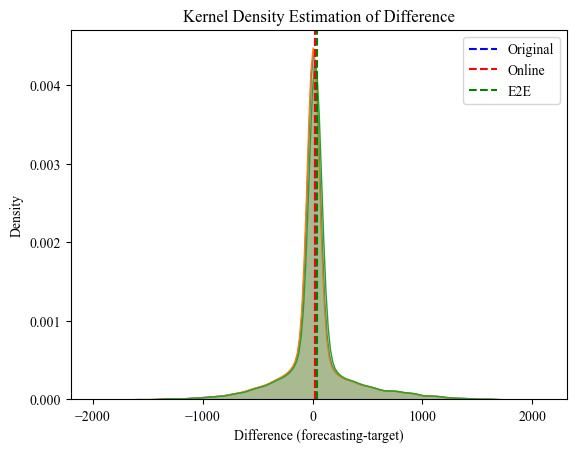

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
difference_org =  forecasts_pv_org[0.5]-targets_pv_list
difference= forecasts_pv[0.5]-targets_pv_list
difference_e2e= forecasts_pv_e2e[0.5]-targets_pv_list
# difference_org = difference_org[17::24]
# difference = difference[17::24]
# difference_e2e = difference_e2e[17::24]
mean_difference_org = np.mean(difference_org)
mean_difference = np.mean(difference)
mean_difference_e2e = np.mean(difference_e2e)
variance_difference = np.var(difference)
variance_difference_org = np.var(difference_org)
variance_difference_e2e = np.var(difference_e2e)
print('Std variance_difference_org:',np.sqrt(variance_difference_org))
print('Mean_difference_org:',mean_difference_org)
print('Std variance_difference:',np.sqrt(variance_difference))
print('Mean_difference:',mean_difference)
print('Std variance_difference_e2e:',np.sqrt(variance_difference_e2e))
print('Mean_difference_e2e:',mean_difference_e2e)

# 使用 seaborn 进行核密度估计并绘制分布图
sns.kdeplot(difference_org, shade=True)
plt.axvline(mean_difference_org, color='b', linestyle='--', label='Original')
sns.kdeplot(difference, shade=True)
plt.axvline(mean_difference, color='r', linestyle='--', label='Online')
sns.kdeplot(difference_e2e, shade=True)
plt.axvline(mean_difference_e2e, color='g', linestyle='--', label='E2E')
plt.title('Kernel Density Estimation of Difference')
plt.xlabel('Difference (forecasting-target)')
plt.ylabel('Density')
plt.legend()
plt.show()

Std variance_difference_org: 125.85845468299739
Std variance_difference: 125.21538386276
Std variance_difference_e2e: 128.31752615429784


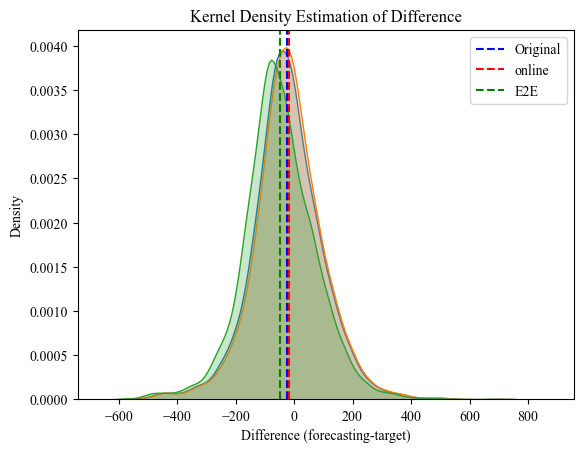

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 假设 targets_load_list 和 forecasts_load_org[0.5] 以及 forecasts_load[0.5] 已经定义
# 计算差值
difference_org =  forecasts_load_org[0.5] - targets_load_list
difference =  forecasts_load[0.5] - targets_load_list
difference_e2e =  forecasts_load_e2e[0.5] - targets_load_list
# 计算差值的均值和方差
mean_difference_org = np.mean(difference_org)
mean_difference = np.mean(difference)
mean_difference_e2e = np.mean(difference_e2e)
variance_difference = np.var(difference)
variance_difference_org = np.var(difference_org)
variance_difference_e2e = np.var(difference_e2e)

# 输出标准差
print('Std variance_difference_org:', np.sqrt(variance_difference_org))
print('Std variance_difference:', np.sqrt(variance_difference))
print('Std variance_difference_e2e:', np.sqrt(variance_difference_e2e))


# 使用 seaborn 进行核密度估计并绘制分布图
sns.kdeplot(difference_org, shade=True)
plt.axvline(mean_difference_org, color='b', linestyle='--', label='Original')
sns.kdeplot(difference, shade=True)
plt.axvline(mean_difference, color='r', linestyle='--', label='online')
sns.kdeplot(difference_e2e, shade=True)
plt.axvline(mean_difference_e2e, color='g', linestyle='--', label='E2E')
plt.title('Kernel Density Estimation of Difference')
plt.xlabel('Difference (forecasting-target)')
plt.ylabel('Density')
plt.legend()
plt.show()

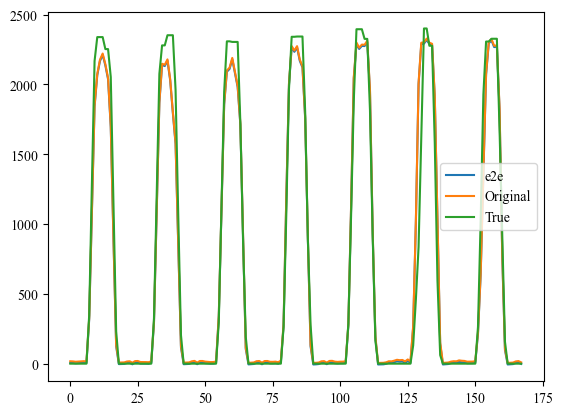

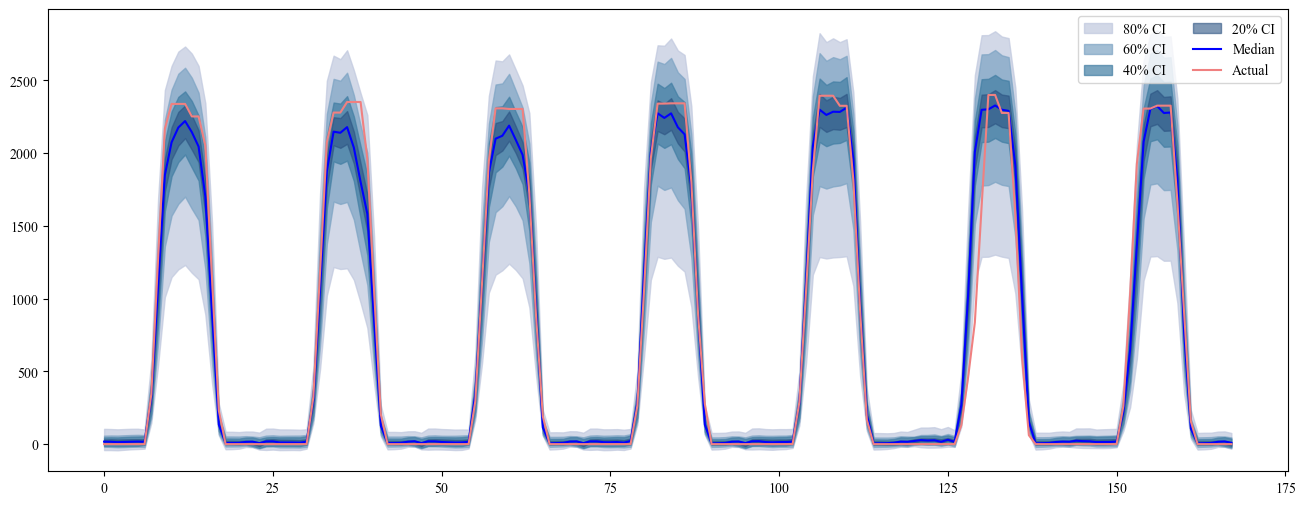

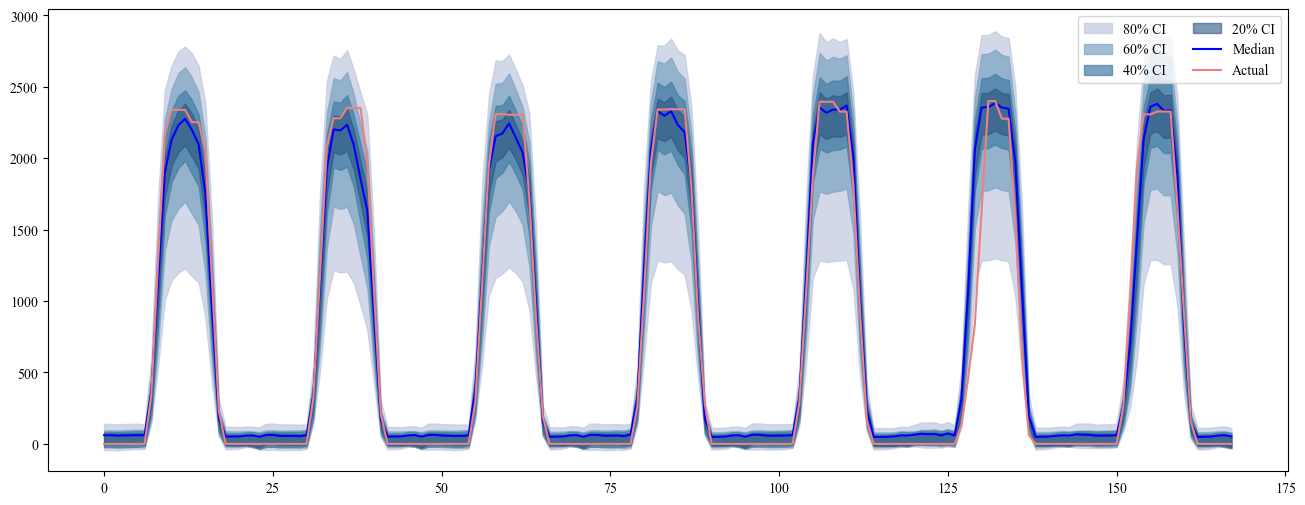

Pinball Loss: 38.39374632325909
Winkler Score_0.1: 829.2901232168003
MAE: 83.46670424808266
RMSE: 167.94793059449827
Pinball Loss: 42.4503619362197
Winkler Score_0.1: 869.1431603328506
MAE: 100.19079473721926
RMSE: 168.72745337954888


In [101]:
start=24*280
end=start+24*7

plt.plot(forecasts_pv[0.5][start:end],label='e2e')
plt.plot(forecasts_pv_org[0.5][start:end],label='Original')
plt.plot(targets_pv_list[start:end],label='True')
plt.legend()
plt.show()
quantiles_list_pv_for_plot_org={}
quantiles_list_pv_for_plot={}
quantiles_list_pv_for_plot_e2e={}
for i in args_train.quantiles:
    quantiles_list_pv_for_plot_org[i]=forecasts_pv_org[i][start:end]
    quantiles_list_pv_for_plot[i]=forecasts_pv[i][start:end]
    quantiles_list_pv_for_plot_e2e[i]=forecasts_pv_e2e[i][start:end]

plot_quantiles(quantiles_list_pv_for_plot_org, targets_pv_list[start:end])
plot_quantiles(quantiles_list_pv_for_plot_e2e, targets_pv_list[start:end])
calculate_accuracy(args_train, quantiles_list_pv_for_plot_org, targets_pv_list[start:end])
calculate_accuracy(args_train, quantiles_list_pv_for_plot_e2e, targets_pv_list[start:end])


In [44]:
def plot_quantiles(quantile_list,targets):
    x = range(len(targets))
    color_list=['#c0c8de', '#7ca3c3', '#427ea3', '#2c5382']
    plt.figure(figsize=(16, 6))
    plt.fill_between(x, quantile_list[0.1], quantile_list[0.9],  color=color_list[0], alpha=0.7, label='80% CI')
    plt.fill_between(x, quantile_list[0.2], quantile_list[0.8], color=color_list[1], alpha=0.7, label='60% CI')
    plt.fill_between(x, quantile_list[0.3], quantile_list[0.7],  color=color_list[2], alpha=0.7, label='40% CI')
    plt.fill_between(x, quantile_list[0.4], quantile_list[0.6], color=color_list[3], alpha=0.6, label='20% CI')
    plt.plot(x,quantile_list[0.5],color='blue',label='Median')
    plt.plot(x,targets,color='lightcoral',label='Actual')
    plt.legend(ncol=2)
    plt.show()
